In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/ct
%load_ext autoreload
%autoreload 2

Mounted at /content/drive
/content/drive/MyDrive/ct


In [ ]:
!ls # skip this line if you have cloned tigre earlier
!git clone https://github.com/CERN/TIGRE.git

In [2]:
%cd TIGRE/
!pip install . --user #restart session after installation of module

/content/drive/MyDrive/ct/TIGRE
Processing /content/drive/MyDrive/ct/TIGRE
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pytigre: filename=pytigre-3.0.0-cp311-cp311-linux_x86_64.whl size=10452755 sha256=c73d63a30f2f46085ee77383b1446c5d3de6fca5048f7e3441b1f91d2fbdb034
  Stored in directory: /tmp/pip-ephem-wheel-cache-vqg4_sq8/wheels/db/5b/0f/46cf0b44c4938f29af3f00b7ffb166311de7bbe27b04c8bf34
Successfully built pytigre


In [3]:
%cd .. # testing
!python3 TIGRE/Python/example.py

/content/drive/MyDrive/ct
0: Tesla T4
{'name': 'Tesla T4', 'devices': [0]}
OSSART algorithm in progress.
Estimated time until completion : 00:00:27
RMSE fdk:
376.54437
RMSE ossart
212.95981
Figure(640x480)


helper functions and imports

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import tigre
from tigre.utilities import gpu
from skimage.data import shepp_logan_phantom
from skimage.transform import resize, radon

def fftshift(x):
    for dim in range(len(x.shape)):
        n = x.shape[dim]
        p2 = n - n//2
        x = torch.roll(x, shifts=p2, dims=dim)
    return x

def ifftshift(x):
    for dim in range(len(x.shape)):
        n = x.shape[dim]
        p2 = n//2
        x = torch.roll(x, shifts=p2, dims=dim)
    return x

def bilinear_interpolate_fft(fft_img, x_coords, y_coords):
    """Bilinear interpolation of complex FFT using grid_sample (concise)"""
    H, W = fft_img.shape
    gx = (2 * x_coords / (W - 1)) - 1
    gy = (2 * y_coords / (H - 1)) - 1
    grid = torch.stack([gx, gy], dim=1)[None, None]  # (1,1,N,2)

    real = F.grid_sample(fft_img.real[None, None], grid,
                         mode='bilinear', align_corners=True).squeeze()
    imag = F.grid_sample(fft_img.imag[None, None], grid,
                         mode='bilinear', align_corners=True).squeeze()
    return real + 1j * imag

a

Processing angle 10 degrees...


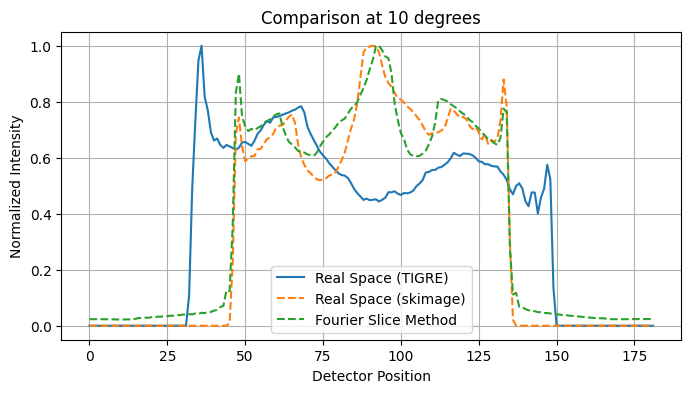

Processing angle 20 degrees...


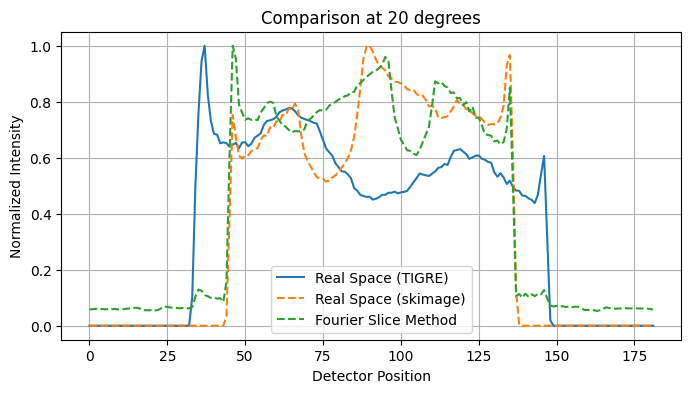

Processing angle 30 degrees...


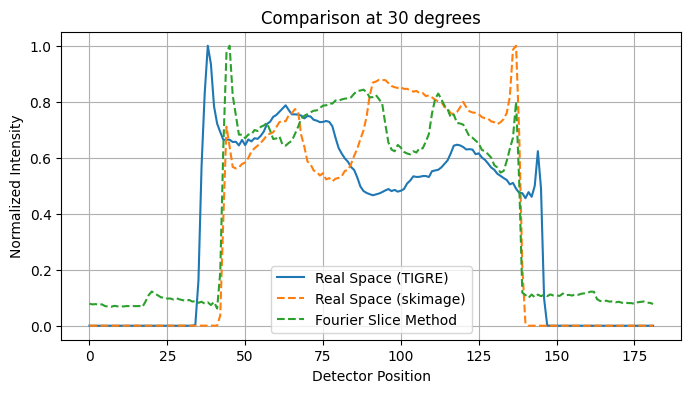

Processing angle 40 degrees...


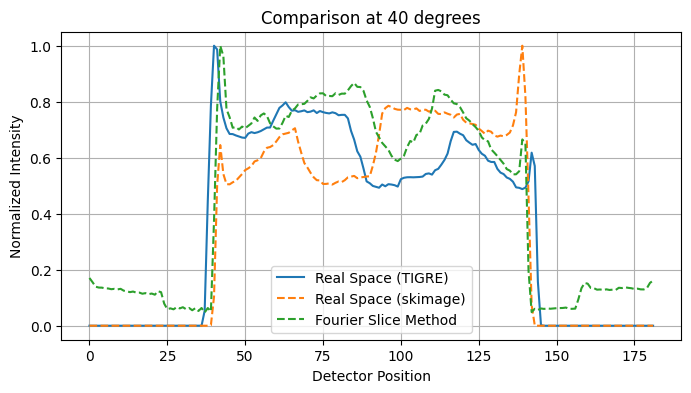

Processing angle 50 degrees...


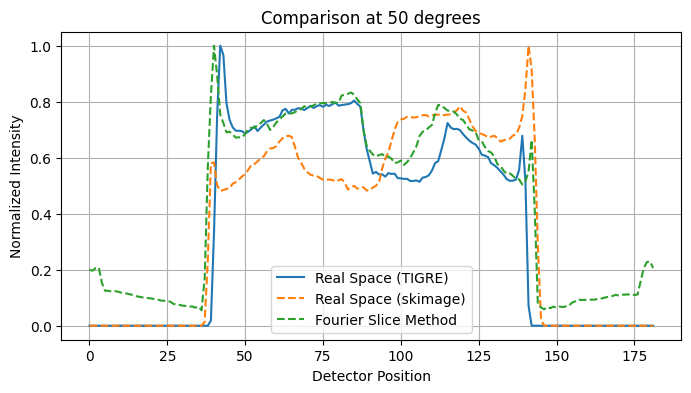

Processing angle 60 degrees...


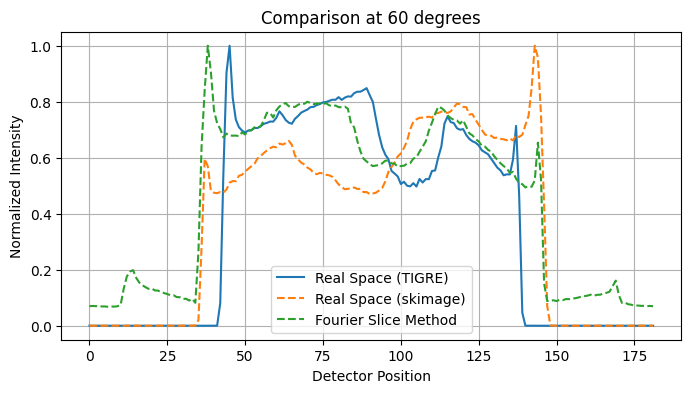

Processing angle 70 degrees...


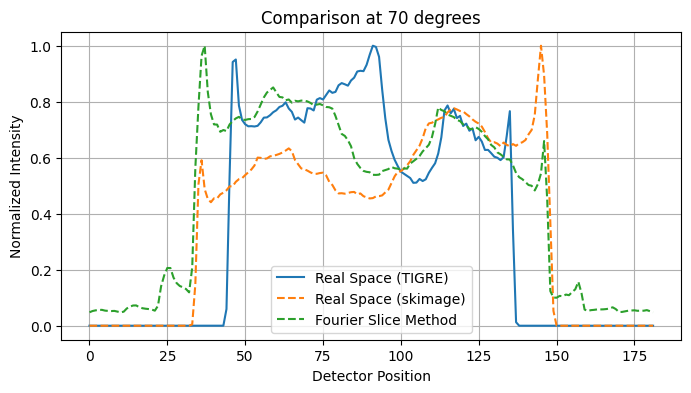

Processing angle 80 degrees...


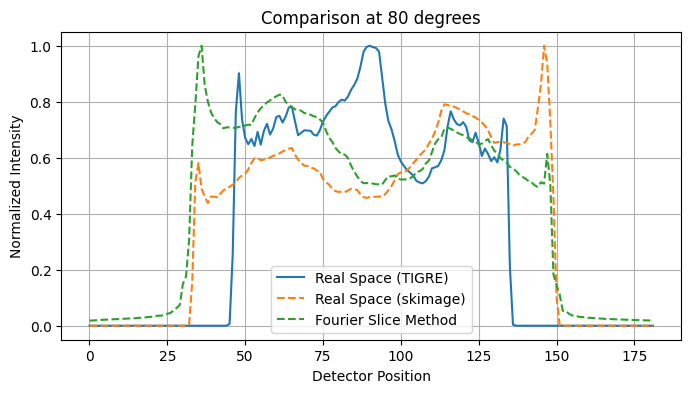

Processing angle 90 degrees...


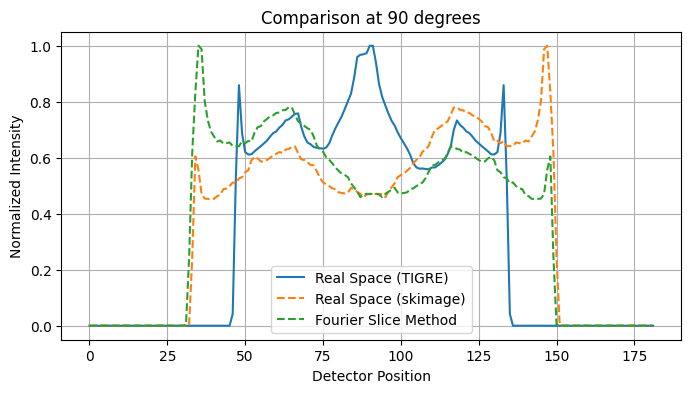

Processing angle 100 degrees...


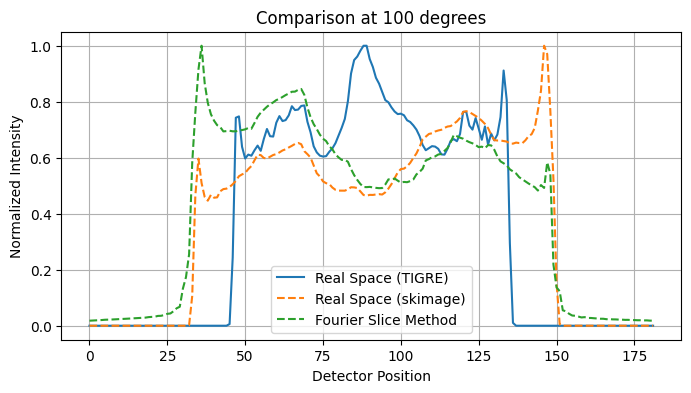

Processing angle 110 degrees...


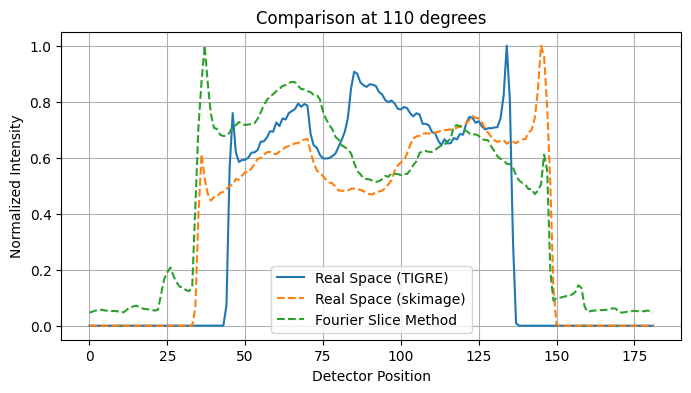

Processing angle 120 degrees...


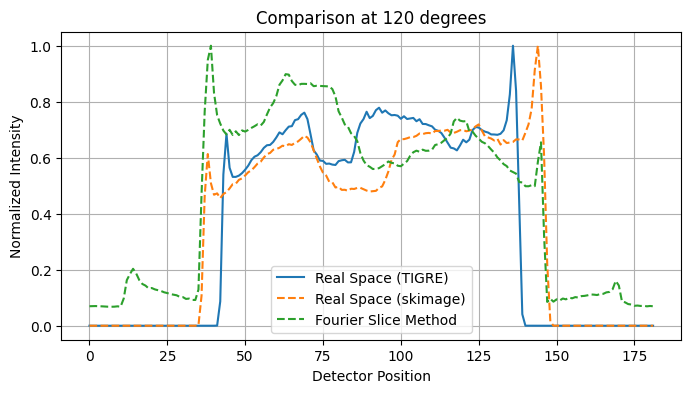

Processing angle 130 degrees...


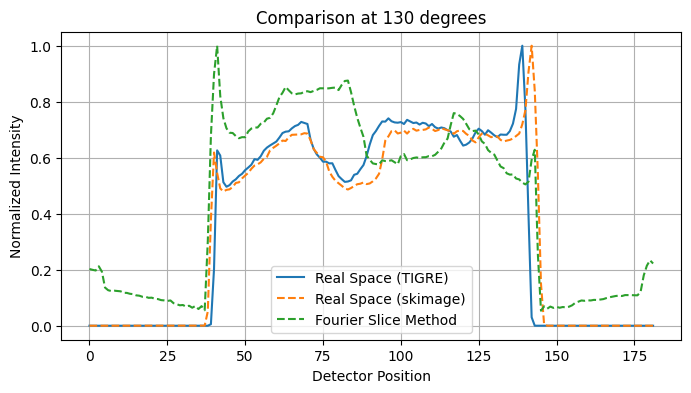

Processing angle 140 degrees...


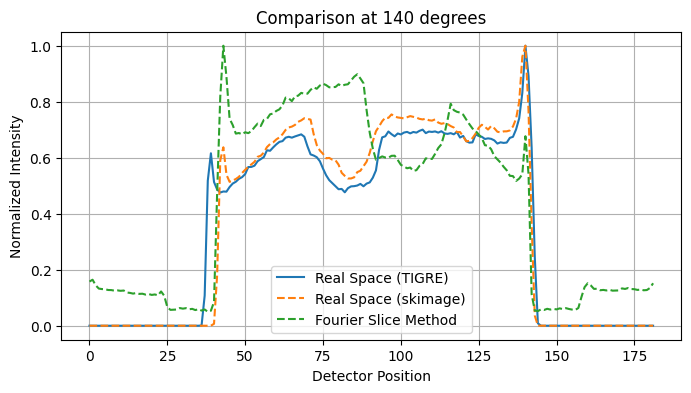

Processing angle 150 degrees...


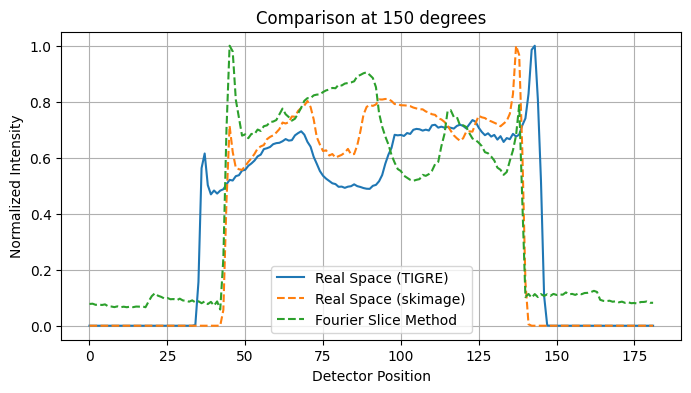

Processing angle 160 degrees...


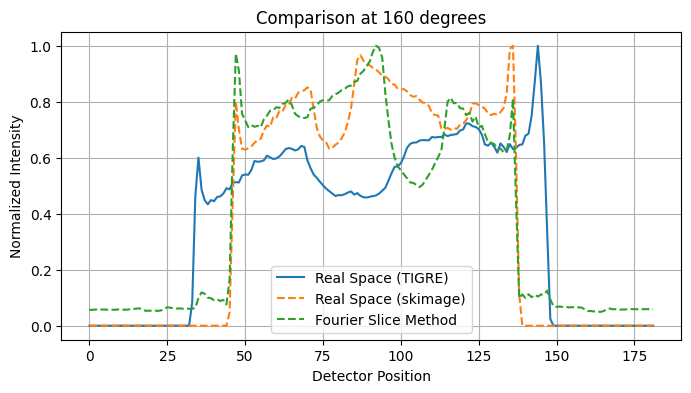

Processing angle 170 degrees...


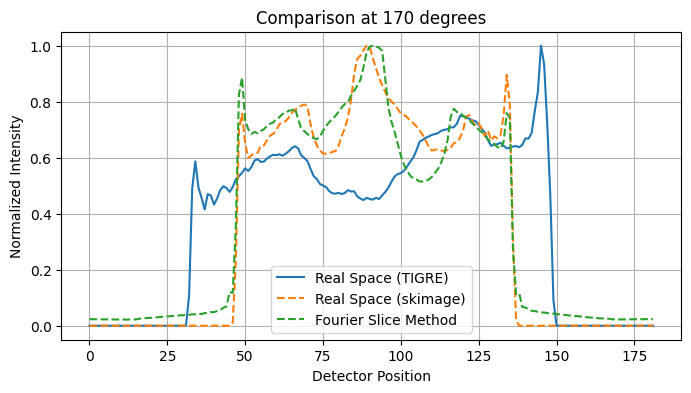


==== MSE per angle ====
Angle  10° → MSE = 0.06928
Angle  20° → MSE = 0.05970
Angle  30° → MSE = 0.04278
Angle  40° → MSE = 0.02387
Angle  50° → MSE = 0.02092
Angle  60° → MSE = 0.04475
Angle  70° → MSE = 0.06744
Angle  80° → MSE = 0.08200
Angle  90° → MSE = 0.07959
Angle 100° → MSE = 0.08220
Angle 110° → MSE = 0.06757
Angle 120° → MSE = 0.05268
Angle 130° → MSE = 0.03201
Angle 140° → MSE = 0.03279
Angle 150° → MSE = 0.05081
Angle 160° → MSE = 0.06080
Angle 170° → MSE = 0.06902


In [2]:
# Step 1: Load Phantom
img_np = shepp_logan_phantom()
img_np = resize(img_np, (128, 128))
img = torch.tensor(img_np, dtype=torch.float32)

# Step 2: Pad Image based on sqrt(2)
n = img.shape[0]
padded_size = int(np.ceil(n * np.sqrt(2)))
if padded_size % 2 == 1:
    padded_size += 1  # make even

pad = (padded_size - n) // 2
img_padded = F.pad(img.unsqueeze(0).unsqueeze(0), (pad, pad, pad, pad), mode='constant', value=0).squeeze()

# Optional: Circular mask
xx, yy = torch.meshgrid(torch.arange(padded_size), torch.arange(padded_size), indexing='ij')
center = padded_size // 2
mask = ((xx - center)**2 + (yy - center)**2) <= (n//2)**2
img_padded = img_padded * mask.float()

# Step 3: Compute 2D FFT
fft_img = fftshift(torch.fft.fft2(ifftshift(img_padded)))

# Step 4: Set TIGRE geometry
img_tigre = img_padded.unsqueeze(0).numpy()  # (1, padded_size, padded_size)

geo = tigre.geometry()
geo.mode = 'parallel'
geo.DSD = 1000
geo.DSO = 500
geo.nVoxel = np.array([1, padded_size, padded_size])
geo.sVoxel = np.array([1, 1, 1])
geo.dVoxel = geo.sVoxel / geo.nVoxel
geo.nDetector = np.array([1, padded_size])
geo.sDetector = np.array([1, 1])
geo.dDetector = geo.sDetector / geo.nDetector
geo.offOrigin = np.array([0,0,0])
geo.offDetector = np.array([0,0])
geo.accuracy = 0.5

# Step 5: Define angles
angles_to_test = np.arange(10, 180, 10)
mse_list = []

# Middle point of FFT image
y_mid = x_mid = padded_size // 2
diag_len = padded_size

for angle_deg in angles_to_test:
    print(f"Processing angle {angle_deg} degrees...")

    # (a) Real-space projection using TIGRE
    real_proj = tigre.Ax(img_tigre, geo, np.array([np.deg2rad(angle_deg)])).squeeze()
    real_proj = torch.tensor(real_proj, dtype=torch.float32)
    real_proj_skimage = radon(img_tigre[0,:,:], theta=[angle_deg], circle=True).squeeze()

    # (b) Fourier Slice
    theta = torch.deg2rad(torch.tensor(angle_deg, dtype=torch.float32))
    steps = torch.arange(-diag_len//2, diag_len//2, dtype=torch.float32)
    x_coords = x_mid + steps * torch.cos(theta)
    y_coords = y_mid + steps * torch.sin(theta)

    samples = bilinear_interpolate_fft(fft_img, x_coords, y_coords)

    # (c) Inverse 1D FFT
    projection_fft_side = ifftshift(torch.fft.ifft(ifftshift(samples))).real

    # (d) Normalize
    real_proj /= torch.max(torch.abs(real_proj))
    projection_fft_side /= torch.max(torch.abs(projection_fft_side))
    real_proj_skimage /= np.max(real_proj_skimage)

    # (e) Match lengths if needed
    if projection_fft_side.shape[0] != real_proj.shape[0]:
        projection_fft_side = F.interpolate(projection_fft_side[None, None, :], size=real_proj.shape[0], mode='linear', align_corners=True).squeeze()

    # (f) Plot
    plt.figure(figsize=(8, 4))
    plt.plot(real_proj.numpy(), label='Real Space (TIGRE)')
    plt.plot(real_proj_skimage, '--', label='Real Space (skimage)')
    plt.plot(projection_fft_side.numpy(), '--', label='Fourier Slice Method')
    plt.title(f'Comparison at {angle_deg} degrees')
    plt.xlabel('Detector Position')
    plt.ylabel('Normalized Intensity')
    plt.legend()
    plt.grid(True)
    plt.show()

    # (g) Compute MSE
    mse = torch.mean((real_proj - projection_fft_side)**2).item()
    mse_list.append(mse)

print("\n==== MSE per angle ====")
for angle, mse in zip(angles_to_test, mse_list):
    print(f"Angle {angle:>3}° → MSE = {mse:.5f}")

Sinogram comparison

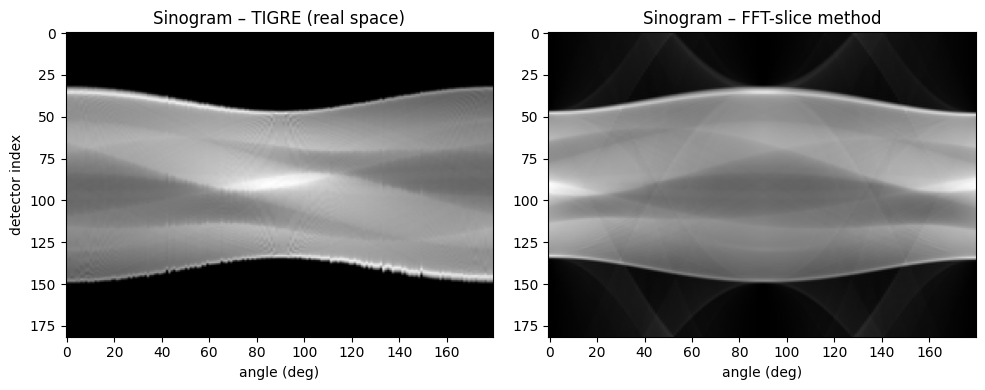

In [4]:
# ---------------------------------------------------------------
# CT sinogram comparison: TIGRE real-space vs. FFT-slice method
# ---------------------------------------------------------------

# ---------- 1. phantom & padding -----------------------------------
N = 128
phantom_np = resize(shepp_logan_phantom(), (N, N), anti_aliasing=True)
phantom = torch.tensor(phantom_np, dtype=torch.float32)

det_len = int(np.ceil(np.sqrt(2) * N))          # full diagonal
if det_len % 2:                                  # force even
    det_len += 1
pad = (det_len - N) // 2
img = F.pad(phantom[None, None], (pad, pad, pad, pad)).squeeze()

# ---------- 2. centred 2-D FFT -------------------------------------
fft_img = fftshift(torch.fft.fft2(ifftshift(img)))

# ---------- 3. TIGRE geometry --------------------------------------
geo = tigre.geometry()
geo.mode        = 'parallel'
geo.DSD, geo.DSO = 1000, 500
geo.nVoxel      = np.array([1, det_len, det_len])
geo.sVoxel      = np.array([1, 1, 1])
geo.dVoxel      = geo.sVoxel / geo.nVoxel
geo.nDetector   = np.array([1, det_len])
geo.sDetector   = np.array([1, 1])
geo.dDetector   = geo.sDetector / geo.nDetector
geo.offOrigin   = np.array([0, 0, 0])
geo.offDetector = np.array([0, 0])
geo.accuracy    = 0.5

volume = img.unsqueeze(0).numpy()               # (1, Y, X)

# ---------- 4. build sinograms -------------------------------------
angles = np.arange(0, 180, 1)                   # 0° … 179°
num_angles = len(angles)

sinogram_tigre = np.zeros((det_len, num_angles), dtype=np.float32)
sinogram_fft   = np.zeros_like(sinogram_tigre)

mid = det_len // 2
coords = torch.arange(-mid, mid, dtype=torch.float32)

for k, deg in enumerate(angles):
    theta = np.deg2rad(deg).astype(np.float32)

    # (a) TIGRE projection
    sinogram_tigre[:, k] = tigre.Ax(volume, geo, np.array([theta])).squeeze()

    # (b) FFT-slice projection
    x = mid + coords * np.cos(theta)
    y = mid + coords * np.sin(theta)
    slice_c = bilinear_interpolate_fft(fft_img, x, y)
    proj_fft = ifftshift(torch.fft.ifft(ifftshift(slice_c))).real
    sinogram_fft[:, k] = proj_fft.numpy()

# ---------- 5. normalise for display -------------------------------
sinogram_tigre /= np.max(np.abs(sinogram_tigre))
sinogram_fft   /= np.max(np.abs(sinogram_fft))

# ---------- 6. plot -------------------------------------------------
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(sinogram_tigre, cmap='gray', aspect='auto')
plt.title('Sinogram – TIGRE (real space)')
plt.xlabel('angle (deg)')
plt.ylabel('detector index')

plt.subplot(1, 2, 2)
plt.imshow(sinogram_fft, cmap='gray', aspect='auto')
plt.title('Sinogram – FFT-slice method')
plt.xlabel('angle (deg)')

plt.tight_layout()
plt.show()